# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### [Optional] Set up Google Drive Connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643-project/spam_classification'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__init__.py', 'run_details.md', 'notes.md', 'sms_classification_results.json', 'sms_losses.png', '3.pdf', 'sms_analysis.py', 'accuracy-plot.pdf', 'enron_spam_data.zip', 'loss-plot.pdf', 'train.zip', '.ipynb_checkpoints', 'enron_spam_data', '__pycache__', 'spam_classification', 'train_plots.py', 'train.py', 'spam_classification.ipynb']


In [4]:

import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
sys.path.append(GOOGLE_DRIVE_PATH)

model_directory = os.path.dirname(GOOGLE_DRIVE_PATH)
sys.path.append(model_directory)

In [5]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/cs7643-project/spam_classification',
 '/content/drive/MyDrive/cs7643-project']

In [6]:
# if running locally set GOOGLE PATH
import sys

if 'google.colab' in sys.modules:
    print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
    GOOGLE_DRIVE_PATH = '.'
    print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/cs7643-project/spam_classification`


### Import Modules

In [7]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.1 MB/s eta 0:00:00


In [8]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [9]:
import torch
print("torch version:", version("torch"))

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")

torch version: 2.6.0+cu124
Using device = cuda


In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
from torch import nn

In [12]:
import pandas as pd

In [13]:
import urllib
from pathlib import Path
import time
from tqdm import tqdm

# 1. Implement a GPT-2 Model

In [14]:
from model.gpt import GPTModel, text_to_token_ids, token_ids_to_text, generate_text_simple, generate, print_model_stats, TransformerBlock
from model.load_model import load_weights
from model.lora_gpt import LoRALayer, LinearWithLoRA, replace_linear_with_lora, replace_linear_with_lora_last_n

## 1.0 Utils

In [15]:
from transformers import GPT2Model

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

def get_raw_gpt(model_name):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    return GPTModel(base_config_copy)

def get_pretrained_gpt_model(model_name, verbose=True):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    gpt_model = GPTModel(base_config_copy)

    hf_pretrained_gpt = GPT2Model.from_pretrained(model_names[model_name], cache_dir="checkpoints")
    load_weights(gpt_model, hf_pretrained_gpt, base_config_copy)

    if verbose:
        print_model_stats(gpt_model, model_name)

    return gpt_model

In [16]:
def convert_to_lora_model(model: GPTModel, rank: int, alpha: int, last_n_trf_blocks=None) -> GPTModel:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters before: {total_params:,}")

    for param in model.parameters():
        param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters after: {total_params:,}")

    if last_n_trf_blocks is not None:
        replace_linear_with_lora_last_n(model, n=last_n_trf_blocks, rank=rank, alpha=alpha)
    else:
        replace_linear_with_lora(model, rank=rank, alpha=alpha)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters: {total_params:,}")
    model.to(device)
    return model

## 1.1 Sanity Check Creating GPT Model

In [17]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

torch.manual_seed(123)
test_raw_gpt = GPTModel(GPT_CONFIG_124M)
test_raw_gpt.eval()  # disable dropout

start_context = "Hello, I am"

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))
encoded_tensor = text_to_token_ids(start_context, tokenizer)

print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
print("\nInput text:", start_context)
print("Encoded input text:", encoded_tensor)
print("encoded_tensor.shape:", encoded_tensor.shape)

out_token_ids = generate_text_simple(
    model=test_raw_gpt,
    token_ids=encoded_tensor,
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
decoded_text = token_ids_to_text(out_token_ids, tokenizer)

print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
print("\nOutput:", out_token_ids)
print("Output length:", len(out_token_ids[0]))
print("Output text:", decoded_text)

[50256]

                      IN

Input text: Hello, I am
Encoded input text: tensor([[15496,    11,   314,   716]])
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


In [18]:
total_params = sum(p.numel() for p in test_raw_gpt.parameters())
print(f"Total Parameters: {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in test_raw_gpt.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Total Parameters: 163,009,536
Number of trainable parameters considering weight tying: 124,412,160


In [19]:
print_model_stats(test_raw_gpt, "GPT-124M")

Model Name: GPT-124M
	Total Parameters: 163,009,536
	Total Memory Requirement: 621.83 MB


## 1.2 Sanity Check Loading Pre-trained Weights

In [20]:
CHOOSE_MODEL = "gpt2-small (124M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
test_pretrained_gpt = get_pretrained_gpt_model(CHOOSE_MODEL, verbose=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [21]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_pretrained_gpt.to(device),
    # token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    token_ids=text_to_token_ids("The state capital of New Jersey is Newark. The state capital of California is", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 The state capital of New Jersey is Newark. The state capital of California is San Francisco.

The state capital of New York City is Brooklyn. The state capital of New Jersey is Newark.

The state capital of


## 1.3 Sanity check LoRA model

In [22]:
test_lora_gpt = get_pretrained_gpt_model("gpt2-small (124M)", verbose=False)

In [23]:
total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in test_lora_gpt.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 163,037,184
Total trainable parameters after: 0


In [24]:
# replace_linear_with_lora(test_lora_gpt, rank=16, alpha=16)
replace_linear_with_lora_last_n(test_lora_gpt, n=2, rank=16, alpha=16)

total_params = sum(p.numel() for p in test_lora_gpt.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Applying LoRA with rank=16, alpha=16 to the last 2 transformer blocks (indices 10 to 11).
Total trainable LoRA parameters: 1,258,768


In [25]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=test_lora_gpt.to(device),
    token_ids=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves forward, but it's not enough.

"I'm not going to sit here and say, 'I'm not going to do this,'


# 3. The Verdict Dataset Loaders

In [26]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

In [27]:
class SpamDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=None, pad_token_id=50256):
        self.data = dataframe

        # Convert to string and check for NaN values
        self.data['Message'] = self.data['Message'].astype(str)

        # Pre-tokenize texts with error handling
        self.encoded_texts = []
        for i, text in enumerate(self.data["Message"]):
            try:
                encoded = tokenizer.encode(text)
                self.encoded_texts.append(encoded)
            except Exception as e:
                print(f"Error encoding text at index {i}: {text}")
                print(f"Error message: {str(e)}")
                # Use an empty sequence as fallback
                self.encoded_texts.append([])

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

        # Truncate sequences if they are longer than max_length
        self.encoded_texts = [
            encoded_text[:self.max_length] if len(encoded_text) > 0 else [0]
            for encoded_text in self.encoded_texts
        ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

        # Convert labels to integers
        self.labels = [1 if label == "spam" else 0 for label in self.data["Label"]]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.labels[index]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

### Download data

In [28]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip"

zip_path = "enron_spam_data.zip"
extracted_path = "enron_spam_data"
date_file_path = Path(extracted_path)/"enron_spam_data.csv"

# Download the zip file
print(f"Downloading file from {url}...")
urllib.request.urlretrieve(url, zip_path)

# Check if the download was successful
if os.path.exists(zip_path):
    print(f"Download successful. File saved to {zip_path}")

    # Create extraction directory if it doesn't exist
    if not os.path.exists(extracted_path):
        os.makedirs(extracted_path)

    # Extract the zip file
    print(f"Extracting to {extracted_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Check if the CSV file was extracted
    if os.path.exists(date_file_path):
        print(f"Extraction successful. CSV file available at {date_file_path}")
    else:
        print("Extraction completed, but CSV file not found.")
else:
    print("Download failed.")

Download successful. File saved to enron_spam_data.zip
Extracting to enron_spam_data...
Extraction successful. CSV file available at enron_spam_data/enron_spam_data.csv


### Put the data into pandas dataframe:

In [29]:
# Load only the Spam/Ham and Message columns into a DataFrame
df = pd.read_csv(date_file_path, usecols=['Spam/Ham', 'Message'])
df = df.rename(columns={'Spam/Ham': 'Label'})

# Display the first few rows of the DataFrame
print("\nDataFrame loaded successfully. Sample data:")
print(df.head())


DataFrame loaded successfully. Sample data:
                                             Message Label
0                                                NaN   ham
1  gary , production from the high island larger ...   ham
2             - calpine daily gas nomination 1 . doc   ham
3  fyi - see note below - already done .\nstella\...   ham
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...   ham


In [30]:
print(df["Label"].value_counts())

Label
spam    17171
ham     16545
Name: count, dtype: int64


### Take 1000 samples for each label

In [31]:
def create_sample_dataset(df):
    # Sample 1000 instances from each class
    spam_subset = df[df["Label"] == "spam"].sample(500, random_state=123)
    ham_subset = df[df["Label"] == "ham"].sample(500, random_state=123)

    # Combine both subsets
    sample_df = pd.concat([ham_subset, spam_subset])

    # Shuffle the dataset
    sample_df = sample_df.sample(frac=1, random_state=123).reset_index(drop=True)

    return sample_df

sample_df = create_sample_dataset(df)
print(sample_df["Label"].value_counts())

Label
ham     500
spam    500
Name: count, dtype: int64


# 4. Training Loop

In [32]:
from spam_classification.train import calc_batch_loss, calc_loader_loss, calc_loader_accuracy, evaluate_model, generate_and_print_sample, TrainingConfig, TrainingResults, train_model_simple, train_model
from spam_classification.train_plots import plot_losses, plot_accuracies, plot_and_save_learning_rate
import json


In [33]:
def save_training_results(results: TrainingResults, filename: str):
    results_dict = {
        "train_losses": results.train_losses,
        "val_losses": results.val_losses,
        "track_steps_seen": results.track_tokens_seen,
        "train_accuracies": results.train_accuracies,
        "val_accuracies": results.val_accuracies,
    }
    if results.track_lrs is not None:
        results_dict["track_lrs"] = results.track_lrs

    with open(filename, "w") as f:
        json.dump(results_dict, f, indent=4)
        print(f"Training results saved to {filename}")

## 4.2 Simple Train loop

In [34]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [35]:
print(sample_df[:99])

                                              Message Label
0    & who wants to help millions ?  8 is our th...   ham
1   on wall street , people are talking about enro...   ham
2   this is to inform you that we are rolling out ...   ham
3   from : the lottery coordinator ,\ninternationa...  spam
4   stinson ,\ni would like to take a day off tomo...   ham
..                                                ...   ...
94  attached are the new org charts following rece...   ham
95  featuring :\n500 + live camgirls\nwebcam archi...  spam
96  multiple male orgasms\nmore info here\nblight ...  spam
97  fancy some loow prices\nhaveanic e dayhello do...  spam
98  prostheses\n+ + + investor edge weekly dtoi + ...  spam

[99 rows x 2 columns]


In [36]:
# Train/validation ratio
from torch.utils.data import random_split

MAX_LENGTH = GPT_CONFIG_124M["context_length"]

sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(0.8 * len(sample_df))
val_size = len(sample_df) - train_size

dataset = SpamDataset(
    dataframe=sample_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)
print(dataset)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}")
print(train_dataset)
print(f"Validation samples: {len(val_dataset)}")
print(val_dataset)

Training samples: 800
Validation samples: 200


In [37]:
torch.manual_seed(123)

num_workers = 0
batch_size = 8

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

print(train_loader)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [38]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 256])
Label batch dimensions torch.Size([8])


In [39]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")

100 training batches
25 validation batches


### 4.2.1 Sanity check the simple training loop

In [40]:
import time

start_time = time.time()

torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2
training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=20,
    eval_iter=5,
    tokenizer=tokenizer,
)

sanity_check_training_results = train_model_simple(training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 6.783, Val loss 6.789
Ep 1 (Step 000020): Train loss 0.783, Val loss 0.907
Ep 1 (Step 000040): Train loss 0.836, Val loss 0.857
Ep 1 (Step 000060): Train loss 0.851, Val loss 0.932
Ep 1 (Step 000080): Train loss 0.661, Val loss 0.727
Training accuracy: 65.250% | Validation accuracy: 63.500%
Ep 2 (Step 000100): Train loss 0.654, Val loss 0.681
Ep 2 (Step 000120): Train loss 0.677, Val loss 0.652
Ep 2 (Step 000140): Train loss 0.760, Val loss 0.831
Ep 2 (Step 000160): Train loss 0.622, Val loss 0.646
Ep 2 (Step 000180): Train loss 0.482, Val loss 0.535
Training accuracy: 80.125% | Validation accuracy: 69.500%
Training completed in 0.72 minutes.


In [41]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(6, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


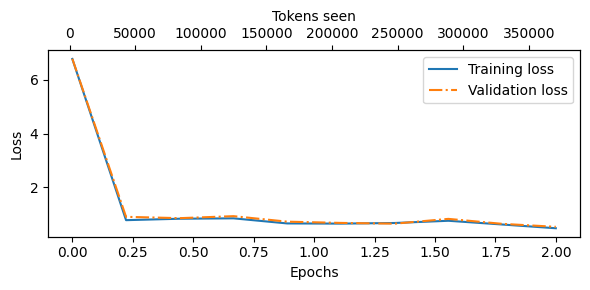

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_values(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

## 4.3 Advanced Train Loop

This training loop adds the following to the simple one:

1) Learning rate warmup

2) Cosine decay (after pear l.r has been reached)

3) Gradient clipping

### 4.3.1 Sanity check the advanced training loop

Typically, the number of warmup steps is between 0.1% to 20% of the total number of steps

In [ ]:
num_epochs = 1
print(len(train_loader))
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(total_steps, warmup_steps)

100
100 20


In [ ]:
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

peak_lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=peak_lr, weight_decay=0.1)
tokenizer = tiktoken.get_encoding("gpt2")

num_epochs = 2
total_training_steps = len(train_loader) * num_epochs
print(f"Total number of training steps: {total_training_steps}")

training_config = TrainingConfig(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=20,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
)

sanity_check_advanced_training_results = train_model(training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Total number of training steps: 200
Ep 1 (Iter 000000): Train loss 9.900, Val loss 9.827
Ep 1 (Iter 000020): Train loss 0.954, Val loss 1.079
Ep 1 (Iter 000040): Train loss 1.620, Val loss 1.810
Ep 1 (Iter 000060): Train loss 0.794, Val loss 0.794
Ep 1 (Iter 000080): Train loss 0.676, Val loss 0.696
Training accuracy: 67.50% | Validation accuracy: 55.00%
Ep 2 (Iter 000100): Train loss 0.673, Val loss 0.674
Ep 2 (Iter 000120): Train loss 0.639, Val loss 0.629
Ep 2 (Iter 000140): Train loss 0.559, Val loss 0.596
Ep 2 (Iter 000160): Train loss 0.600, Val loss 0.542
Ep 2 (Iter 000180): Train loss 0.475, Val loss 0.523
Training accuracy: 85.00% | Validation accuracy: 75.00%
Training completed in 0.55 minutes.


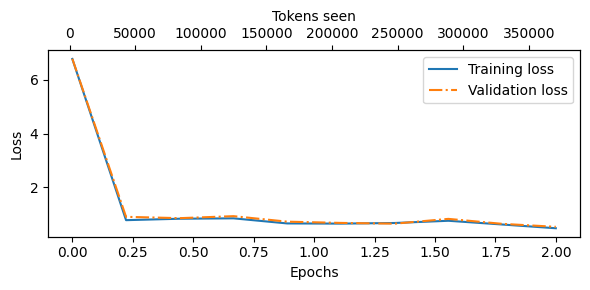

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(sanity_check_training_results.train_losses))
plot_values(epochs_tensor,
            sanity_check_training_results.track_tokens_seen,
            sanity_check_training_results.train_losses,
            sanity_check_training_results.val_losses)

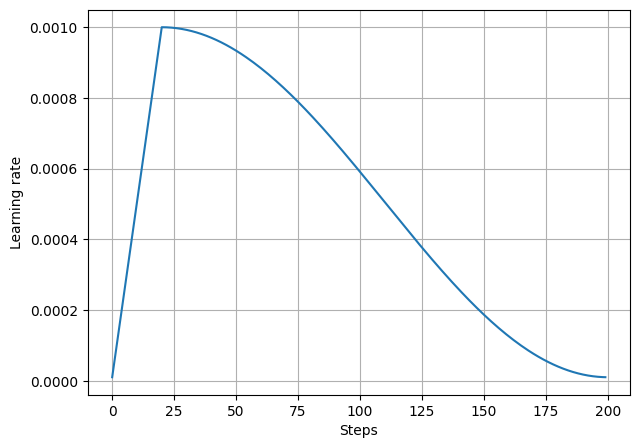

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(range(len(sanity_check_advanced_training_results.track_lrs)), sanity_check_advanced_training_results.track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.grid()
plt.show()

# 6. Fine Tuning

## 6.1 Prepare the Dataset

In [216]:
from spam_classification.train import calc_batch_loss, calc_loader_loss, calc_loader_accuracy, evaluate_model, generate_and_print_sample, TrainingConfig, TrainingResults, train_model_simple, train_model
from spam_classification.train_plots import plot_losses, plot_accuracies, plot_and_save_learning_rate
import json
import time
import matplotlib.pyplot as plt

# Available Models Names|
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
MAX_LENGTH = 512
print(BASE_CONFIG)
CHOOSE_MODEL = "gpt2-small (124M)"
# CHOOSE_MODEL = "gpt2-medium (355M)"

{'vocab_size': 50257, 'context_length': 1024, 'drop_rate': 0.0, 'qkv_bias': True, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


In [217]:
print(df)
print(df["Label"].value_counts())

                                                 Message Label
0                                                    NaN   ham
1      gary , production from the high island larger ...   ham
2                 - calpine daily gas nomination 1 . doc   ham
3      fyi - see note below - already done .\nstella\...   ham
4      fyi .\n- - - - - - - - - - - - - - - - - - - -...   ham
...                                                  ...   ...
33711  hello , welcome to gigapharm onlinne shop .\np...  spam
33712  i got it earlier than expected and it was wrap...  spam
33713  are you ready to rock on ? let the man in you ...  spam
33714  learn how to last 5 - 10 times longer in\nbed ...  spam
33715  hi : )\ndo you need some softwares ? i can giv...  spam

[33716 rows x 2 columns]
Label
spam    17171
ham     16545
Name: count, dtype: int64


In [218]:
# ham_short_df = df[(df['Label'] == 'ham') & (df['Message'].str.len() <= 512)].reset_index(drop=True)

# # Filter for spam messages with 512 characters or less
# spam_short_df = df[(df['Label'] == 'spam') & (df['Message'].str.len() <= 512)].reset_index(drop=True)

ham_short_df = df[(df['Label'] == 'ham')].reset_index(drop=True)

# Filter for spam messages with 512 characters or less
spam_short_df = df[(df['Label'] == 'spam')].reset_index(drop=True)

print("\nFiltered dataset statistics:")
print(f"Ham messages ≤ 512 chars: {len(ham_short_df)} ({len(ham_short_df) / len(df[df['Label'] == 'ham']) * 100:.2f}% kept)")
print(f"Spam messages ≤ 512 chars: {len(spam_short_df)} ({len(spam_short_df) / len(df[df['Label'] == 'spam']) * 100:.2f}% kept)")


Filtered dataset statistics:
Ham messages ≤ 512 chars: 16545 (100.00% kept)
Spam messages ≤ 512 chars: 17171 (100.00% kept)


In [219]:
# Sample exactly 6000 (or maximum available) from each category
ham_sample = ham_short_df.sample(n=1000, random_state=42).reset_index(drop=True)
spam_sample = spam_short_df.sample(n=1000, random_state=42).reset_index(drop=True)

# Combine the samples
emails_12k = pd.concat([ham_sample, spam_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

print(emails_12k)

                                                Message Label
0     shop at the internet ' s # 1 ink store and see...  spam
1     as communicated to you in an email dated septe...   ham
2     remove\nmongoose jobholdergolden churn clubroo...  spam
3     we are making a number of significant organiza...   ham
4     crouch ,\nbefore we continue - very important ...  spam
...                                                 ...   ...
1995  home for sale ? list with\nus !\nbuying a\nhom...  spam
1996  you have not tried cialls yet ?\nthan you cann...  spam
1997  craig and kim ,\nas you know , i have obtained...   ham
1998  wanna see girls naked on your pc live ?\nit ' ...  spam
1999                   hello !\npama kowbtemin mine '\n  spam

[2000 rows x 2 columns]


In [220]:
from torch.utils.data import random_split

train_size = int(0.8 * len(emails_12k))
val_size = len(emails_12k) - train_size

dataset = SpamDataset(
    dataframe=emails_12k,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
)
print(dataset)

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}")
print(train_dataset)
print(f"Validation samples: {len(val_dataset)}")
print(val_dataset)

Training samples: 1600
Validation samples: 400


## 6.2 Create data loaders

In [221]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

print(train_loader)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [222]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 512])
Label batch dimensions torch.Size([8])


In [223]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")

200 training batches
50 validation batches


## 6.3 Load Pretrained GPT2

In [224]:
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_gpt_m.to(device)

Model Name: gpt2-small (124M)
	Total Parameters: 163,037,184
	Total Memory Requirement: 621.94 MB


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
     

In [225]:
torch.manual_seed(123)
sample_text = "Every effort moves you"
token_ids = generate_text_simple(
    model=pretrained_gpt_m.to(device),
    token_ids=text_to_token_ids(sample_text, tokenizer).to(device),
    max_new_tokens=15,
    context_size=MAX_LENGTH,
)

generated_text = token_ids_to_text(token_ids, tokenizer)
print("Output text:\n", generated_text)

Output text:
 Every effort moves you forward.

The first step is to understand the importance of your work


In [226]:
for param in pretrained_gpt_m.parameters():
    param.requires_grad = False

num_classes = 2
pretrained_gpt_m.out_head = torch.nn.Linear(in_features=model_configs[CHOOSE_MODEL]["emb_dim"], out_features=num_classes)
pretrained_gpt_m.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (multi_head_att): MultiHeadAttention(
     

In [227]:
train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device, num_batches=10)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.3}%")
print(f"Validation accuracy: {val_accuracy*100:.3f}%")

Training accuracy: 48.8%
Validation accuracy: 56.250%


#### This is pretrained model, we expect this to be around 50%, which means like flipping coin, model cannot distinguish between spam and non-spam messages yet

## 6.4 Finetune on email 12k

In [228]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)
        train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device, num_batches=5)
        val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print(f"Training accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")

In [229]:
def finetune_model(run_name, input_rank, input_trf):
    # 1) Initialize a Pre-trained GPT model
    CHOOSE_MODEL = "gpt2-medium (355M)"
    # CHOOSE_MODEL = "gpt2-small (124M)"
    # CHOOSE_MODEL = "gpt2-large (774M)"
    pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)

    num_classes = 2
    pretrained_gpt_m.out_head = torch.nn.Linear(in_features=model_configs[CHOOSE_MODEL]["emb_dim"], out_features=num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pretrained_gpt_m.to(device)

    pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=input_rank, alpha=input_rank, last_n_trf_blocks=input_trf)
    print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

    # 2) Finetune the model
    start_time = time.time()
    torch.manual_seed(123)

    optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 2
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(0.2 * total_steps) # 20% warmup

    training_config = TrainingConfig(
        model=pretrained_gpt_m,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=25,
        eval_iter=5,
        tokenizer=tokenizer,
        warmup_steps=warmup_steps,
        initial_lr=1e-5,
        min_lr=1e-5,
        run_name=run_name,
    )

    training_results = train_model_simple(training_config)
    # training_results = train_model(training_config)

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    # 3) Saving and logging
    directory_path = f"{GOOGLE_DRIVE_PATH}/spam_classification/data/runs/{run_name}/"
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 3a) Save GPT model
    # model_file_path = directory_path + "pretrained_gpt_m.pth"
    # torch.save(pretrained_gpt_m.state_dict(), model_file_path)

    # 3b) Save training results
    training_results_file_path = directory_path + "training_results.json"
    save_training_results(training_results, training_results_file_path)

    # 3c) Plot learning curves
    plot_losses(training_config, training_results, directory_path + "loss_curves.png")
    # plot_accuracies(training_config, training_results, directory_path + "accuracy_curves.png")

    return training_results, training_config

In [176]:
run_name = "gpt-large-lora"
training_results, training_config = finetune_model(run_name, 16, 24)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 7,094,304
Training loss: 1.2458058595657349
Validation loss: 1.217194664478302
Training accuracy: 47.50%
Validation accuracy: 57.50%
Ep 1 (Step 000000): Train loss 0.964, Val loss 1.050


KeyboardInterrupt: 

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 18 transformer blocks (indices 6 to 23).
Total trainable LoRA parameters: 5,324,832
Training loss: 1.5408523082733154
Validation loss: 1.1756078004837036
Training accuracy: 52.50%
Validation accuracy: 50.00%
Ep 1 (Step 000000): Train loss 1.537, Val loss 0.944
Ep 1 (Step 000025): Train loss 0.684, Val loss 0.676
Ep 1 (Step 000050): Train loss 0.646, Val loss 0.673
Ep 1 (Step 000075): Train loss 0.652, Val loss 0.678
Ep 1 (Step 000100): Train loss 0.627, Val loss 0.538
Ep 1 (Step 000125): Train loss 0.233, Val loss 0.224
Ep 1 (Step 000150): Train loss 0.179, Val loss 0.145
Ep 1 (Step 000175): Train loss 0.361, Val loss 0.516
Training accuracy: 88.188% | Validation accuracy: 88.500%
Ep 2 (Step 000200): Train loss 0.325, Val loss 0.146
Ep 2 (Step 000225): Train

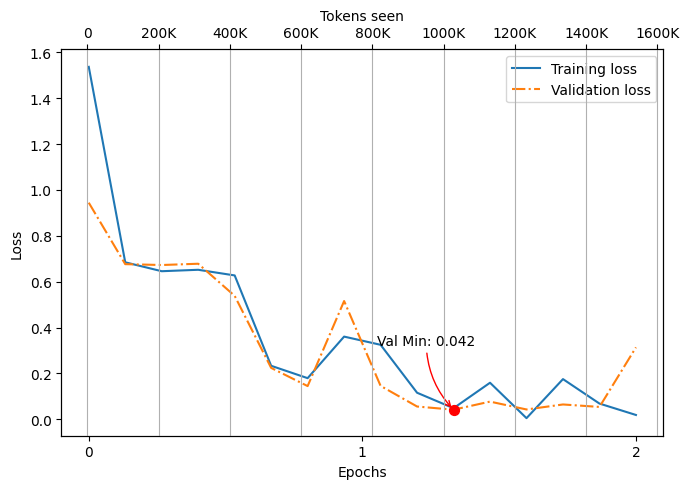

In [230]:
run_name = "gpt-med-lora-trf-second-18"
training_results, training_config = finetune_model(run_name, 16, 18)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 20 transformer blocks (indices 4 to 23).
Total trainable LoRA parameters: 5,914,656
Training loss: 3.178534650802612
Validation loss: 3.608193612098694
Training accuracy: 47.50%
Validation accuracy: 50.00%
Ep 1 (Step 000000): Train loss 2.695, Val loss 1.497
Ep 1 (Step 000025): Train loss 0.640, Val loss 0.665
Ep 1 (Step 000050): Train loss 0.634, Val loss 0.663
Ep 1 (Step 000075): Train loss 0.659, Val loss 0.699
Ep 1 (Step 000100): Train loss 0.624, Val loss 0.577
Ep 1 (Step 000125): Train loss 0.695, Val loss 0.632
Ep 1 (Step 000150): Train loss 0.600, Val loss 0.667
Ep 1 (Step 000175): Train loss 0.586, Val loss 0.560
Training accuracy: 61.812% | Validation accuracy: 59.000%
Ep 2 (Step 000200): Train loss 0.631, Val loss 0.547
Ep 2 (Step 000225): Train l

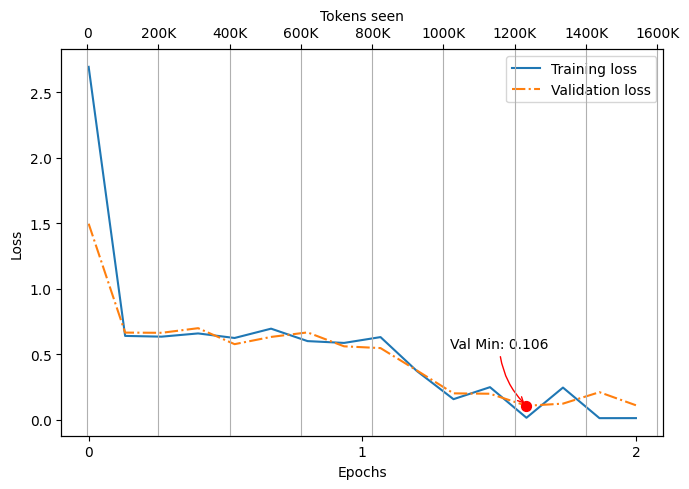

In [231]:
run_name = "gpt-med-lora-trf-second-20"
training_results, training_config = finetune_model(run_name, 16, 20)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 22 transformer blocks (indices 2 to 23).
Total trainable LoRA parameters: 6,504,480
Training loss: 5.2310059547424315
Validation loss: 3.608193612098694
Training accuracy: 45.00%
Validation accuracy: 50.00%
Ep 1 (Step 000000): Train loss 2.762, Val loss 1.597
Ep 1 (Step 000025): Train loss 0.658, Val loss 0.670
Ep 1 (Step 000050): Train loss 0.633, Val loss 0.662
Ep 1 (Step 000075): Train loss 0.649, Val loss 0.655
Ep 1 (Step 000100): Train loss 0.625, Val loss 0.576
Ep 1 (Step 000125): Train loss 0.656, Val loss 0.608
Ep 1 (Step 000150): Train loss 0.575, Val loss 0.640
Ep 1 (Step 000175): Train loss 0.598, Val loss 0.572
Training accuracy: 78.250% | Validation accuracy: 76.500%
Ep 2 (Step 000200): Train loss 0.529, Val loss 0.383
Ep 2 (Step 000225): Train 

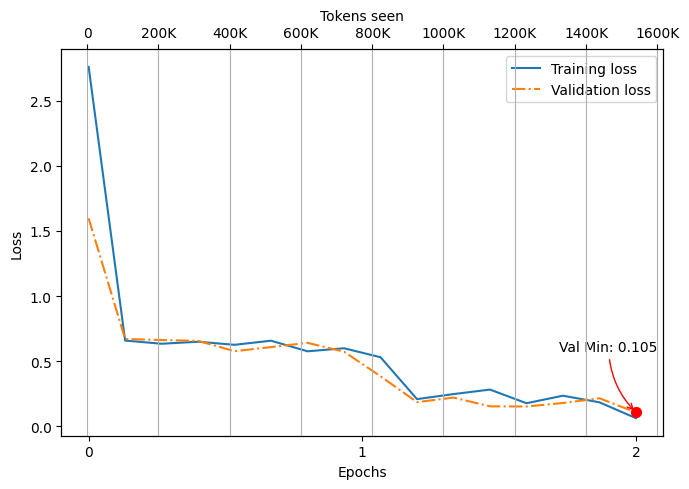

In [232]:
run_name = "gpt-med-lora-trf-second-22"
training_results, training_config = finetune_model(run_name, 16, 22)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 354,825,218
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 7,094,304
Training loss: 6.408168315887451
Validation loss: 3.608193612098694
Training accuracy: 50.00%
Validation accuracy: 50.00%
Ep 1 (Step 000000): Train loss 2.713, Val loss 1.487
Ep 1 (Step 000025): Train loss 0.624, Val loss 0.669
Ep 1 (Step 000050): Train loss 0.679, Val loss 0.647
Ep 1 (Step 000075): Train loss 0.650, Val loss 0.646
Ep 1 (Step 000100): Train loss 0.642, Val loss 0.582
Ep 1 (Step 000125): Train loss 0.682, Val loss 0.610
Ep 1 (Step 000150): Train loss 0.563, Val loss 0.604
Ep 1 (Step 000175): Train loss 0.578, Val loss 0.540
Training accuracy: 80.500% | Validation accuracy: 80.000%
Ep 2 (Step 000200): Train loss 0.422, Val loss 0.459
Ep 2 (Step 000225): Train l

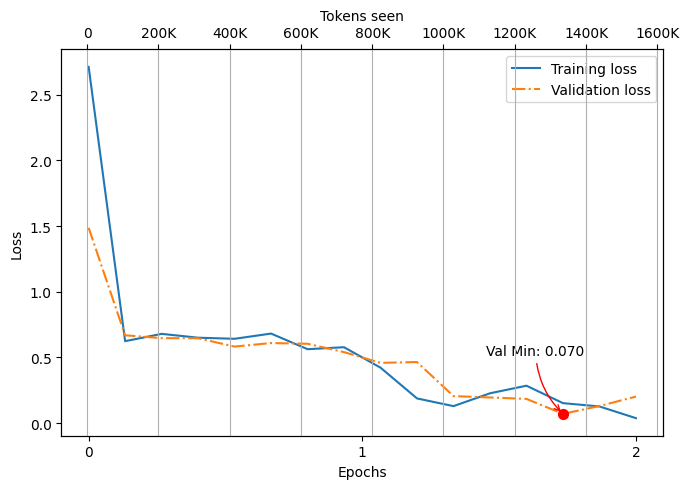

In [233]:
run_name = "gpt-med-lora-trf-second-24"
training_results, training_config = finetune_model(run_name, 16, 24)